In [1]:
%matplotlib inline
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
from IPython.display import display

# Load calc agg features

In [2]:
from pathlib import Path
# Set up file paths
notebook_dir = Path.cwd().resolve()
data_save_path = (notebook_dir / '..' /  'Data').resolve()

print(f"Data path: {data_save_path}")

Data path: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\Data


In [3]:
DATA_DIR = (notebook_dir / '..' /  '..' /  'Data').resolve()
print(DATA_DIR)

DATASETS = {
    "heart_diagnoses_1": "heart_diagnoses_1.csv",
    "laboratory_events_codes_2": "laboratory_events_codes_2.csv",
    "microbiology_events_codes_3": "microbiology_events_codes_3.csv",
    "procedure_code_4": "procedure_code_4.csv",
}

Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data


In [4]:
paths = [f"{DATA_DIR}/{DATASETS[dataset].replace('.csv', '_agg_features.csv')}" for dataset in DATASETS.keys()]
dfs = [pd.read_csv(Path(path)) for path in paths]
len(dfs), 

(4,)

In [5]:
for df, name in zip(dfs, DATASETS.keys()):
    print(f"\nDataset: {name}")
    print("="*80)
    print(f"Shape: {df.shape}")
    print("Columns:")
    print(df.columns)
    display(df.head(2))
    display(df.describe())


Dataset: heart_diagnoses_1
Shape: (4864, 18)
Columns:
Index(['subject_id', 'hadm_id', 'gender', 'age', 'is_dead', 'charttime',
       'icd_code', 'icd_cat', 'imaging_variety', 'doc_complexity_index',
       'cardiac_comorbidity_score', 'has_heart', 'has_hf', 'has_arr',
       'has_ami', 'has_arrest', 'has_valvular', 'has_inflammatory'],
      dtype='object')


,subject_id,hadm_id,gender,age,is_dead,charttime,icd_code,icd_cat,imaging_variety,doc_complexity_index,cardiac_comorbidity_score,has_heart,has_hf,has_arr,has_ami,has_arrest,has_valvular,has_inflammatory
0,10000980,26913865,F,75.0,1,2189-07-04 03:00:00,I21,acute_mi,4,21.972737,1,1,0,0,1,0,0,0
1,10000980,29654838,F,75.0,1,2188-01-06 03:00:00,I50,heart_failure,3,23.273517,1,1,1,0,0,0,0,0


,subject_id,hadm_id,age,is_dead,imaging_variety,doc_complexity_index,cardiac_comorbidity_score,has_heart,has_hf,has_arr,has_ami,has_arrest,has_valvular,has_inflammatory
count,4.864000e+03,4.864000e+03,1363.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.0,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000
mean,1.510717e+07,2.501745e+07,68.978723,0.081826,3.297081,22.306007,0.802220,1.0,0.297492,0.139391,0.295847,0.000411,0.057977,0.011102
std,2.938761e+06,2.873736e+06,14.973358,0.274127,0.529166,1.271144,0.398366,0.0,0.457202,0.346390,0.456470,0.020276,0.233724,0.104790
min,1.000098e+07,2.000446e+07,18.000000,0.000000,2.000000,17.229959,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.252385e+07,2.260252e+07,60.000000,0.000000,3.000000,21.481264,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.507553e+07,2.503238e+07,70.000000,0.000000,3.000000,22.309730,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.764939e+07,2.746833e+07,81.000000,0.000000,4.000000,23.174916,1.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.999860e+07,2.999967e+07,95.000000,1.000000,6.000000,27.656885,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Dataset: laboratory_events_codes_2
Shape: (4855, 34)
Columns:
Index(['subject_id', 'hadm_id', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio',
       'lab_time_span_hours', 'unique_lab_tests', 'unique_examination_groups',
       'fluid_diversity', 'unique_analysis_batches', 'has_labs',
       'max_blood_glucose', 'max_blood_lactate', 'max_blood_anion gap',
       'max_blood_creatinine', 'max_blood_urea nitrogen',
       'max_blood_potassium', 'max_blood_sodium', 'min_blood_hemoglobin',
       'min_blood_hematocrit', 'max_blood_c-reactive protein',
       'max_urine_glucose', 'max_urine_creatinine', 'max_urine_urea nitrogen',
       'max_urine_sodium', 'max_urine_protein', 'max_gas_pO2', 'max_gas_pCO2',
       'max_gas_pH', 'max_gas_base excess', 'count_cbc', 'count_blood_gas',
       'count_liver', 'count_cardiac'],
      dtype='object')


,subject_id,hadm_id,num_labs,abnormal_ratio,qc_fail_ratio,lab_time_span_hours,unique_lab_tests,unique_examination_groups,fluid_diversity,unique_analysis_batches,...,max_urine_sodium,max_urine_protein,max_gas_pO2,max_gas_pCO2,max_gas_pH,max_gas_base excess,count_cbc,count_blood_gas,count_liver,count_cardiac
0,10000980,26913865.0,166,0.0,0.024096,140.466667,45,12,1,136,...,NaN,NaN,NaN,NaN,73.2000,NaN,59.0,0.0,7.0,10.0
1,10000980,29654838.0,59,0.0,0.000000,33.433333,35,8,1,53,...,NaN,NaN,NaN,NaN,1.7119,NaN,18.0,0.0,2.0,7.0


,subject_id,hadm_id,num_labs,abnormal_ratio,qc_fail_ratio,lab_time_span_hours,unique_lab_tests,unique_examination_groups,fluid_diversity,unique_analysis_batches,...,max_urine_sodium,max_urine_protein,max_gas_pO2,max_gas_pCO2,max_gas_pH,max_gas_base excess,count_cbc,count_blood_gas,count_liver,count_cardiac
count,4.855000e+03,4.855000e+03,4855.000000,4855.000000,4855.000000,4855.000000,4855.000000,4855.000000,4855.000000,4855.000000,...,676.000000,903.000000,1202.000000,1197.000000,4713.000000,1203.000000,4855.000000,4855.000000,4855.000000,4855.000000
mean,1.510805e+07,2.501709e+07,240.493306,0.000086,0.020154,115.134343,47.647168,9.218332,1.552626,119.398764,...,57.590237,85.225692,26.367305,6.441000,59.284682,2.929343,69.267971,23.490834,5.736972,7.646344
std,2.939544e+06,2.874953e+06,513.277369,0.000800,0.014587,111.872999,21.559055,5.192832,0.645785,72.279992,...,33.727525,113.275414,18.725899,1.798151,105.428314,5.146037,121.124737,164.087887,20.387880,9.589104
min,1.000098e+07,2.000446e+07,3.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,3.000000,...,10.000000,0.100000,2.261000,3.059000,0.516800,-15.000000,0.000000,0.000000,0.000000,0.000000
25%,1.251722e+07,2.260072e+07,79.000000,0.000000,0.011236,44.233333,31.000000,6.000000,1.000000,67.000000,...,29.000000,30.000000,10.640000,5.320000,1.356600,0.000000,27.000000,0.000000,0.000000,3.000000
50%,1.507734e+07,2.503202e+07,136.000000,0.000000,0.019002,81.100000,43.000000,8.000000,1.000000,103.000000,...,54.000000,30.000000,19.152000,6.118000,60.200000,2.000000,42.000000,0.000000,0.000000,6.000000
75%,1.765293e+07,2.746949e+07,259.000000,0.000000,0.027141,149.150000,60.000000,11.000000,2.000000,158.000000,...,81.000000,100.000000,43.191750,7.182000,85.000000,5.000000,80.000000,6.000000,5.000000,10.000000
max,1.999860e+07,2.999967e+07,22580.000000,0.019802,0.285714,1257.800000,175.000000,54.000000,5.000000,543.000000,...,212.000000,660.000000,73.017000,19.152000,3825.000000,33.000000,4840.000000,8875.000000,910.000000,240.000000



Dataset: microbiology_events_codes_3
Shape: (2756, 8)
Columns:
Index(['subject_id', 'hadm_id', 'has_micro', 'total_microbio_events',
       'unique_specimen_types', 'unique_organisms', 'resistant_ratio',
       'unique_antibiotics'],
      dtype='object')


,subject_id,hadm_id,has_micro,total_microbio_events,unique_specimen_types,unique_organisms,resistant_ratio,unique_antibiotics
0,10000980,26913865,1,1,1,0,0.0,0
1,10002155,23822395,1,12,4,0,0.0,0


,subject_id,hadm_id,has_micro,total_microbio_events,unique_specimen_types,unique_organisms,resistant_ratio,unique_antibiotics
count,2.756000e+03,2.756000e+03,2756.0,2756.000000,2756.000000,2756.000000,2756.000000,2756.000000
mean,1.561649e+07,2.503819e+07,1.0,5.655298,2.033745,0.356313,0.022155,1.425617
std,3.105062e+06,2.879683e+06,0.0,8.387583,1.431543,0.715932,0.097512,3.740287
min,1.000098e+07,2.000790e+07,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.294230e+07,2.262280e+07,1.0,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.569462e+07,2.506436e+07,1.0,2.500000,2.000000,0.000000,0.000000,0.000000
75%,1.847125e+07,2.752187e+07,1.0,7.000000,3.000000,1.000000,0.000000,0.000000
max,1.999767e+07,2.999967e+07,1.0,122.000000,15.000000,9.000000,1.000000,23.000000



Dataset: procedure_code_4
Shape: (3459, 6)
Columns:
Index(['subject_id', 'hadm_id', 'has_procedure', 'total_procedures',
       'unique_icd_codes', 'procedure_span_days'],
      dtype='object')


,subject_id,hadm_id,has_procedure,total_procedures,unique_icd_codes,procedure_span_days
0,10000980,26913865,1,7,7,0.0
1,10002013,24760295,1,2,2,0.0


,subject_id,hadm_id,has_procedure,total_procedures,unique_icd_codes,procedure_span_days
count,3.459000e+03,3.459000e+03,3459.0,3459.000000,3459.000000,3459.000000
mean,1.499381e+07,2.502943e+07,1.0,4.191096,4.058398,1.442324
std,2.868527e+06,2.853466e+06,0.0,2.989024,2.717689,3.541510
min,1.000098e+07,2.000790e+07,1.0,1.000000,1.000000,0.000000
25%,1.249509e+07,2.264270e+07,1.0,2.000000,2.000000,0.000000
50%,1.495295e+07,2.506423e+07,1.0,3.000000,3.000000,0.000000
75%,1.747168e+07,2.747180e+07,1.0,6.000000,6.000000,1.000000
max,1.999850e+07,2.999967e+07,1.0,28.000000,21.000000,43.000000


# Merge

In [6]:
from functools import reduce

# Merge all on ['subject_id', 'hadm_id']
patient_profile = reduce(
    lambda left, right: pd.merge(left, right, on=['subject_id', 'hadm_id'], how='outer'),
    dfs
)

In [7]:
len(patient_profile.columns), patient_profile.columns

(60,
 Index(['subject_id', 'hadm_id', 'gender', 'age', 'is_dead', 'charttime',
        'icd_code', 'icd_cat', 'imaging_variety', 'doc_complexity_index',
        'cardiac_comorbidity_score', 'has_heart', 'has_hf', 'has_arr',
        'has_ami', 'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs',
        'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours',
        'unique_lab_tests', 'unique_examination_groups', 'fluid_diversity',
        'unique_analysis_batches', 'has_labs', 'max_blood_glucose',
        'max_blood_lactate', 'max_blood_anion gap', 'max_blood_creatinine',
        'max_blood_urea nitrogen', 'max_blood_potassium', 'max_blood_sodium',
        'min_blood_hemoglobin', 'min_blood_hematocrit',
        'max_blood_c-reactive protein', 'max_urine_glucose',
        'max_urine_creatinine', 'max_urine_urea nitrogen', 'max_urine_sodium',
        'max_urine_protein', 'max_gas_pO2', 'max_gas_pCO2', 'max_gas_pH',
        'max_gas_base excess', 'count_cbc', 'count_blood_gas'

In [8]:
# Targeted NA handling
has_columns = [col for col in patient_profile.columns if col.startswith('has_')]

print(has_columns)
# Fill indicators with 0 (absent)
patient_profile[has_columns] = patient_profile[has_columns].fillna(0).astype(int)

['has_heart', 'has_hf', 'has_arr', 'has_ami', 'has_arrest', 'has_valvular', 'has_inflammatory', 'has_labs', 'has_micro', 'has_procedure']


In [9]:
# Identify numeric columns (exclude ids/flags)
numeric_cols = [c for c in patient_profile.select_dtypes(include='number').columns
                if c not in ('subject_id', 'hadm_id')]

# Heuristic: detect count-like columns and fill zeros when corresponding has_* indicates absence
count_like_keywords = ('num_', 'total_', 'unique_', 'count', '_count')
count_cols = [c for c in numeric_cols if any(k in c for k in count_like_keywords)]
count_cols

['num_labs',
 'unique_lab_tests',
 'unique_examination_groups',
 'unique_analysis_batches',
 'count_cbc',
 'count_blood_gas',
 'count_liver',
 'count_cardiac',
 'total_microbio_events',
 'unique_specimen_types',
 'unique_organisms',
 'unique_antibiotics',
 'total_procedures',
 'unique_icd_codes']

In [10]:
# mapping heuristics from feature name -> has_ flag (extend if needed)
map_keywords = {
    'lab': 'has_labs',
    'micro': 'has_micro',
    'procedure': 'has_procedure',
    'proc': 'has_procedure',
    'note': 'has_heart',
}

for col in count_cols:
    filled = False
    lname = col.lower()
    for key, has_flag in map_keywords.items():
        if key in lname and has_flag in patient_profile.columns:
            patient_profile.loc[patient_profile[has_flag] == 0, col] = 0
            filled = True
            break
    if not filled:
        # safe fallback: fill remaining NaNs with 0 (counts mean absence)
        patient_profile[col] = patient_profile[col].fillna(0)

# Measurements / statistics: keep NaN but create missing indicators
exclude_from_measure = set(count_cols) | set(has_cols) | {'subject_id', 'hadm_id'}
measurement_cols = [c for c in numeric_cols if c not in exclude_from_measure and c != 'is_dead']

for c in measurement_cols:
    patient_profile[c + '_missing'] = patient_profile[c].isna().astype(int)

NameError: name 'has_cols' is not defined

In [ ]:
patient_profile.describe()

,subject_id,hadm_id,age,is_dead,imaging_variety,doc_complexity_index,cardiac_comorbidity_score,has_heart,has_hf,has_arr,...,max_urine_creatinine_missing_missing,max_urine_urea nitrogen_missing_missing,max_urine_sodium_missing_missing,max_urine_protein_missing_missing,max_gas_pO2_missing_missing,max_gas_pCO2_missing_missing,max_gas_pH_missing_missing,max_gas_base excess_missing_missing,resistant_ratio_missing_missing,procedure_span_days_missing_missing
count,5.166000e+03,5.166000e+03,1363.000000,4864.000000,4864.000000,4864.000000,4864.000000,5166.000000,5166.000000,5166.000000,...,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0,5166.0
mean,1.539306e+07,2.501832e+07,68.978723,0.081826,3.297081,22.306007,0.802220,0.941541,0.280101,0.131243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,3.073751e+06,2.871364e+06,14.973358,0.274127,0.529166,1.271144,0.398366,0.234632,0.449092,0.337698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000098e+07,2.000446e+07,18.000000,0.000000,2.000000,17.229959,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.267767e+07,2.261127e+07,60.000000,0.000000,3.000000,21.481264,1.000000,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.539807e+07,2.502269e+07,70.000000,0.000000,3.000000,22.309730,1.000000,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.812905e+07,2.746995e+07,81.000000,0.000000,4.000000,23.174916,1.000000,1.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.999860e+07,2.999967e+07,95.000000,1.000000,6.000000,27.656885,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
patient_profile.head()

,subject_id,hadm_id,gender,age,is_dead,charttime,icd_code,icd_cat,imaging_variety,doc_complexity_index,...,max_urine_creatinine_missing,max_urine_urea nitrogen_missing,max_urine_sodium_missing,max_urine_protein_missing,max_gas_pO2_missing,max_gas_pCO2_missing,max_gas_pH_missing,max_gas_base excess_missing,resistant_ratio_missing,procedure_span_days_missing
0,10000980,26913865,F,75.0,1.0,2189-07-04 03:00:00,I21,acute_mi,4.0,21.972737,...,1,1,1,1,1,1,0,1,0,0
1,10000980,29654838,F,75.0,1.0,2188-01-06 03:00:00,I50,heart_failure,3.0,23.273517,...,1,1,1,1,1,1,0,1,1,1
2,10002013,24760295,F,NaN,0.0,2160-07-13 03:00:00,I21,acute_mi,4.0,20.214975,...,1,1,1,1,1,1,0,1,1,0
3,10002155,23822395,F,NaN,0.0,2129-08-19 03:00:00,I21,acute_mi,3.0,22.286569,...,0,0,0,1,0,0,0,0,0,0
4,10004457,28723315,M,66.0,0.0,2141-08-14 03:00:00,I35,valvular,3.0,21.351221,...,1,1,1,1,1,1,0,1,1,1


# Completeness Analysis

In [11]:
# Identify the 'has_' indicator columns
has_columns = [ 'has_heart', 'has_labs', 'has_micro', 'has_procedure']
print(f"Data source indicators: {has_columns}")

Data source indicators: ['has_heart', 'has_labs', 'has_micro', 'has_procedure']



COMPLETENESS SUMMARY

Per-Source Availability:
  has_heart: 4,864 patients (94.2%)
  has_labs: 4,855 patients (94.0%)
  has_micro: 2,756 patients (53.3%)
  has_procedure: 3,459 patients (67.0%)

--------------------------------------------------------------------------------
DATA SOURCE COMBINATIONS:
--------------------------------------------------------------------------------
  [1-1-1-1] heart, labs, micro, procedure: 1,932 (37.4%)
  [1-1-0-1] heart, labs, procedure: 1,525 (29.5%)
  [1-1-0-0] heart, labs: 876 (17.0%)
  [1-1-1-0] heart, labs, micro: 522 (10.1%)
  [0-0-1-0] micro: 302 (5.8%)
  [1-0-0-0] heart: 7 (0.1%)
  [1-0-0-1] heart, procedure: 2 (0.0%)


C:\Users\dgars\AppData\Local\Temp\ipykernel_14308\1571333312.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sources, rotation=45, ha='right')


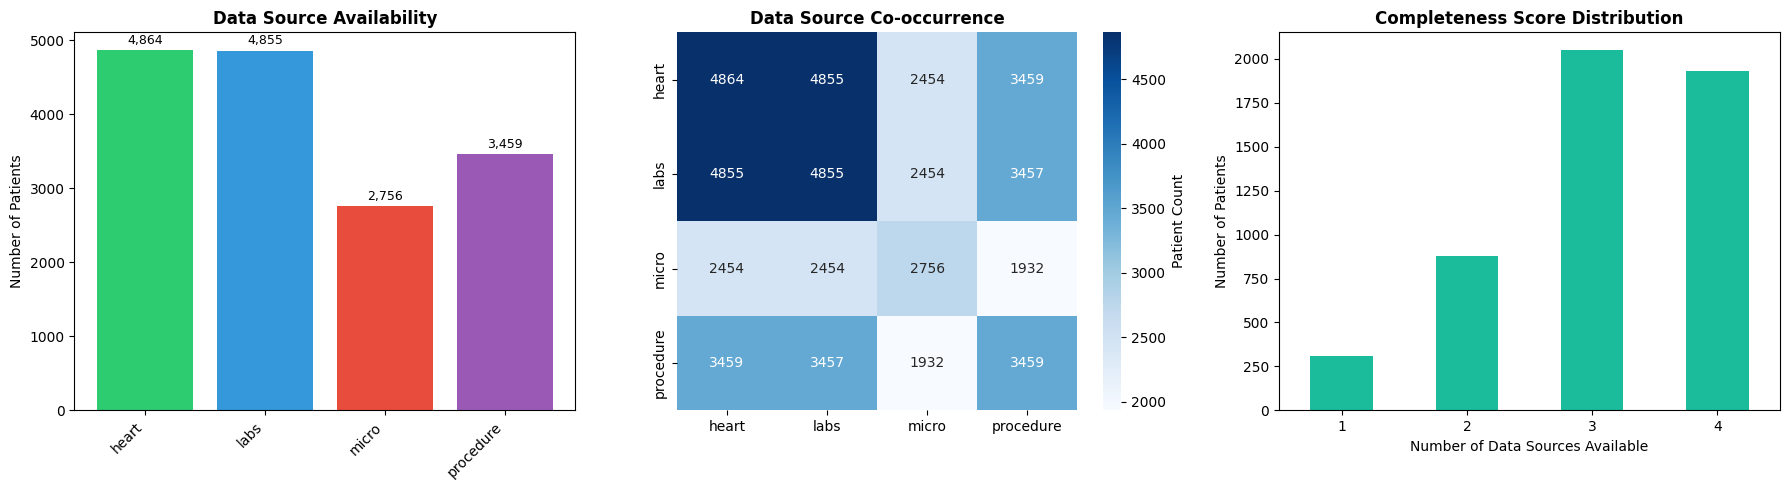


COMPLETENESS SCORE SUMMARY

Total patients: 5,166
Patients with ALL sources: 1,932
Patients with NO sources: 0
Average sources per patient: 3.08


In [12]:
# Completeness Matrix - Check which data sources are available for each patient
completeness = patient_profile[has_columns].copy()

# Summary statistics
print("\n" + "="*80)
print("COMPLETENESS SUMMARY")
print("="*80)

# Per-source completeness
print("\nPer-Source Availability:")
for col in has_columns:
    count = (patient_profile[col] == 1).sum()
    pct = count / len(patient_profile) * 100
    print(f"  {col}: {count:,} patients ({pct:.1f}%)")

# Combination completeness
print("\n" + "-"*80)
print("DATA SOURCE COMBINATIONS:")
print("-"*80)

# Create a combined key for each row
completeness['combination'] = completeness[has_columns].astype(int).astype(str).agg('-'.join, axis=1)
combo_counts = completeness['combination'].value_counts()

# Create readable labels
for combo, count in combo_counts.items():
    sources = [has_columns[i].replace('has_', '') for i, val in enumerate(combo.split('-')) if val == '1']
    sources_str = ', '.join(sources) if sources else 'None'
    pct = count / len(patient_profile) * 100
    print(f"  [{combo}] {sources_str}: {count:,} ({pct:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Bar chart of individual source availability
ax1 = axes[0]
source_counts = [(col.replace('has_', ''), (patient_profile[col] == 1).sum()) for col in has_columns]
sources, counts = zip(*source_counts)
bars = ax1.bar(sources, counts, color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6'][:len(has_columns)])
ax1.set_ylabel('Number of Patients')
ax1.set_title('Data Source Availability', fontweight='bold')
ax1.set_xticklabels(sources, rotation=45, ha='right')
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Heatmap of co-occurrence
ax2 = axes[1]
cooccurrence = pd.DataFrame(index=has_columns, columns=has_columns, dtype=float)
for col1 in has_columns:
    for col2 in has_columns:
        both = ((patient_profile[col1] == 1) & (patient_profile[col2] == 1)).sum()
        cooccurrence.loc[col1, col2] = both

# Rename for display
cooccurrence.index = [c.replace('has_', '') for c in cooccurrence.index]
cooccurrence.columns = [c.replace('has_', '') for c in cooccurrence.columns]

sns.heatmap(cooccurrence.astype(float), annot=True, fmt='.0f', cmap='Blues', 
            ax=ax2, cbar_kws={'label': 'Patient Count'})
ax2.set_title('Data Source Co-occurrence', fontweight='bold')

# Plot 3: Completeness score distribution
ax3 = axes[2]
patient_profile['completeness_score'] = patient_profile[has_columns].sum(axis=1)
patient_profile['completeness_score'].value_counts().sort_index().plot(kind='bar', ax=ax3, color='#1abc9c')
ax3.set_xlabel('Number of Data Sources Available')
ax3.set_ylabel('Number of Patients')
ax3.set_title('Completeness Score Distribution', fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(r'../plots/1.2_completeness_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Final summary
print("\n" + "="*80)
print("COMPLETENESS SCORE SUMMARY")
print("="*80)
print(f"\nTotal patients: {len(patient_profile):,}")
print(f"Patients with ALL sources: {(patient_profile['completeness_score'] == len(has_columns)).sum():,}")
print(f"Patients with NO sources: {(patient_profile['completeness_score'] == 0).sum():,}")
print(f"Average sources per patient: {patient_profile['completeness_score'].mean():.2f}")

## Encode gender

In [13]:
patient_profile["gender"].value_counts(dropna=False)

gender
M      2841
F      2017
NaN     308
Name: count, dtype: int64

In [14]:
if 'patient_profile' in globals() and 'gender' in patient_profile.columns:
    g2 = patient_profile['gender'].astype(str).str.strip().str.upper()
    patient_profile['gender_F'] = (g2 == 'F').astype(int)
    patient_profile['gender_M'] = (g2 == 'M').astype(int)
    patient_profile['gender_missing'] = (~g2.isin(['F', 'M'])).astype(int)
    # drop any legacy encoding to avoid reuse
    patient_profile = patient_profile.drop(columns=['gender_enc'], errors='ignore')
    patient_profile = patient_profile.drop(columns=['gender'], errors='ignore')

In [15]:
for col in ['gender_F', 'gender_M', 'gender_missing']:
    if col in patient_profile.columns:
        print(f"{col} counts:")
        display(patient_profile[col].value_counts(dropna=False))

gender_F counts:


gender_F
0    3149
1    2017
Name: count, dtype: int64

gender_M counts:


gender_M
1    2841
0    2325
Name: count, dtype: int64

gender_missing counts:


gender_missing
0    4858
1     308
Name: count, dtype: int64

# Save big patient profile

In [16]:
patient_profile.to_csv(os.path.join(DATA_DIR, "patient_profile_large.csv"), index=False)

# Corr

In [17]:
patient_profile.columns

Index(['subject_id', 'hadm_id', 'age', 'is_dead', 'charttime', 'icd_code',
       'icd_cat', 'imaging_variety', 'doc_complexity_index',
       'cardiac_comorbidity_score', 'has_heart', 'has_hf', 'has_arr',
       'has_ami', 'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs',
       'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours',
       'unique_lab_tests', 'unique_examination_groups', 'fluid_diversity',
       'unique_analysis_batches', 'has_labs', 'max_blood_glucose',
       'max_blood_lactate', 'max_blood_anion gap', 'max_blood_creatinine',
       'max_blood_urea nitrogen', 'max_blood_potassium', 'max_blood_sodium',
       'min_blood_hemoglobin', 'min_blood_hematocrit',
       'max_blood_c-reactive protein', 'max_urine_glucose',
       'max_urine_creatinine', 'max_urine_urea nitrogen', 'max_urine_sodium',
       'max_urine_protein', 'max_gas_pO2', 'max_gas_pCO2', 'max_gas_pH',
       'max_gas_base excess', 'count_cbc', 'count_blood_gas', 'count_liver',
       'coun

In [18]:
def corr_report(df, features, data_dir=None, plot_name='selected_features_corr.png', threshold=0.60, figsize=(12,10), show_plot=True):
    """
    Compute correlation matrix for given features in df, plot heatmap, and return correlations + high-corr pairs.
    ...
    """
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd

    # keep only existing requested cols
    sel = [c for c in features if c in df.columns]
    if not sel:
        raise ValueError("No requested features found in dataframe.")

    tmp = df[sel].copy()

    # one-hot encode gender into F/M/missing to avoid arbitrary numeric codes
    if 'gender' in tmp.columns:
        g = tmp['gender'].astype(str).str.strip().str.upper()
        tmp['gender_F'] = (g == 'F').astype(int)
        tmp['gender_M'] = (g == 'M').astype(int)
        tmp['gender_missing'] = (~g.isin(['F', 'M'])).astype(int)
        tmp = tmp.drop(columns=['gender'])

    # booleans -> int (FIXED: use vectorized approach)
    bool_cols = tmp.select_dtypes(include='bool').columns
    tmp[bool_cols] = tmp[bool_cols].astype(int)

    # select numeric columns only
    num_tmp = tmp.select_dtypes(include=[np.number]).copy()
    used_features = num_tmp.columns.tolist()
    if len(used_features) < 2:
        raise ValueError("Need at least two numeric features for correlation. Numeric found: " + ", ".join(used_features))

    # correlation
    corr_df = num_tmp.corr()

    # plot heatmap (mask upper triangle)
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    sns.heatmap(corr_df, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                cbar_kws={'label':'corr'})
    plt.title('Correlation matrix — selected features')
    plt.tight_layout()

    # save
    if data_dir is None:
        save_dir = os.path.abspath('.')
    else:
        save_dir = data_dir
    plots_dir = os.path.join(save_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    save_path = os.path.join(plots_dir, plot_name)
    plt.savefig(save_path, dpi=200, bbox_inches='tight')

    if show_plot:
        plt.show()
    else:
        plt.close()

    # extract high-correlation pairs (upper triangle only)
    cols = corr_df.columns.tolist()
    high_pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            val = corr_df.iloc[i, j]
            if pd.notna(val) and abs(val) >= threshold:
                high_pairs.append((cols[i], cols[j], float(val)))

    # print brief report
    print(f"Correlation matrix saved to: {save_path}")
    print(f"Numeric features used ({len(used_features)}): {used_features}")
    print(f"High-corr pairs (|r| >= {threshold}): {len(high_pairs)}")
    for a,b,v in sorted(high_pairs, key=lambda x: -abs(x[2])):
        print(f"  {a} <--> {b}  :  {v:.3f}")

    return corr_df, high_pairs, used_features

In [19]:
#corr_df, high_pairs, used = corr_report(patient_profile, patient_profile.columns.tolist(), data_dir=DATA_DIR, threshold=0.80)

# Further select and compute combined features

Indicator,Formula
- Clinical Activity, mean(log1p(imaging, labs, micro, proc))
- Micro Resistance,resist_ratio * log1p(organisms + specimens)
- History Depth,log1p(hpi_length) + log1p(note_hours)
- Procedure Density,total_procedures / procedure_days
- Metabolic Stress,z(Glu) + z(Lac) + z(AnionGap) - z(Bicarb)
- Renal Injury,z(Cr) + z(BUN) + z(Phos) + z(K)
- Oxygenation,z(pCO2) - z(pO2) - z(pH) - z(BaseExcess)
- Liver/Inflam,z(CRP) + z(AST) + z(ALT) + z(LD)
- Hematologic,z(Hb) + z(Hct) + z(RBC) - z(RDW)
- Renal Failure,z(Serum_Cr) - z(Urine_Cr)
- Recentness,1 / (1 + days_since_last_adm)

In [20]:
patient_profile.columns[:50]

Index(['subject_id', 'hadm_id', 'age', 'is_dead', 'charttime', 'icd_code',
       'icd_cat', 'imaging_variety', 'doc_complexity_index',
       'cardiac_comorbidity_score', 'has_heart', 'has_hf', 'has_arr',
       'has_ami', 'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs',
       'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours',
       'unique_lab_tests', 'unique_examination_groups', 'fluid_diversity',
       'unique_analysis_batches', 'has_labs', 'max_blood_glucose',
       'max_blood_lactate', 'max_blood_anion gap', 'max_blood_creatinine',
       'max_blood_urea nitrogen', 'max_blood_potassium', 'max_blood_sodium',
       'min_blood_hemoglobin', 'min_blood_hematocrit',
       'max_blood_c-reactive protein', 'max_urine_glucose',
       'max_urine_creatinine', 'max_urine_urea nitrogen', 'max_urine_sodium',
       'max_urine_protein', 'max_gas_pO2', 'max_gas_pCO2', 'max_gas_pH',
       'max_gas_base excess', 'count_cbc', 'count_blood_gas', 'count_liver',
       'coun

In [21]:
def compute_indicators_and_run_corr(df, data_dir=None, save_plots=True, corr_threshold=0.70, figsize=(10,8)):
    d = df.copy()
    
    # --- Track components to exclude later ---
    # We will add any raw column used in a formula to this set
    found_components = set()

    # 2. Micro/Resistance Components
    micro_comps = ['resistant_ratio', 'unique_organisms', 'unique_specimen_types']
    for c in micro_comps:
        if c in d.columns:
            found_components.add(c)
    
    if 'resistant_ratio' in d.columns:
        rr = d['resistant_ratio'].fillna(0)
        uo = d['unique_organisms'].fillna(0) if 'unique_organisms' in d.columns else 0
        us = d['unique_specimen_types'].fillna(0) if 'unique_specimen_types' in d.columns else 0
        d['micro_resistance_score'] = rr * np.log1p(uo + us)


    # 4. Procedure Density Components
    if 'total_procedures' in d.columns:
        p_span = 'procedure_span_days'
        if p_span in d.columns: found_components.add(p_span)
        pdays = d[p_span].fillna(1) if p_span in d.columns else 1
        d['procedure_density'] = d['total_procedures'] / pdays.clip(lower=1)

    # 5. Diagnosis Components
    if 'n_diagnoses' in d.columns:
        found_components.add('n_diagnoses')
        d['diagnosis_burden'] = np.log1p(d['n_diagnoses'].fillna(0))

    # --- Analyte Composite Logic ---
    def first_existing(col_candidates):
        for c in col_candidates:
            if c in d.columns:
                return c
        return None

    def robust_z_series(s):
        s = pd.to_numeric(s, errors='coerce')
        med = s.median()
        iqr = s.quantile(0.75) - s.quantile(0.25)
        denom = iqr if iqr > 0 else (s.std() if s.std() > 0 else 1.0)
        return (s.fillna(med) - med) / (denom + 1e-9)

    analyte_candidates = {
        'glucose':       ['max_blood_glucose', 'max_glucose', 'mean_glucose'],
        'lactate':       ['max_blood_lactate', 'max_lactate', 'mean_lactate', 'lactate'],
        'anion_gap':     ['max_blood_anion gap', 'max_blood_anion_gap', 'max_anion_gap', 'anion_gap'],
        'bicarbonate':   ['max_blood_bicarbonate', 'max_bicarbonate', 'total_co2', 'bicarbonate'],
        'creatinine':    ['max_blood_creatinine', 'max_creatinine', 'creatinine'],
        'urea_nitrogen': ['max_blood_urea_nitrogen', 'max_blood_urea nitrogen', 'max_urea_nitrogen', 'bun'],
        'phosphate':     ['max_blood_phosphate', 'max_phosphate', 'phosphate'],
        'potassium':     ['max_blood_potassium', 'max_potassium', 'potassium'],
        'pO2':           ['max_gas_pO2', 'max_pO2', 'po2', 'pao2'],
        'pCO2':          ['max_gas_pCO2', 'max_pCO2', 'pco2', 'paco2'],
        'pH':            ['max_gas_pH', 'max_pH', 'ph'],
        'base_excess':   ['max_gas_base excess', 'max_gas_base_excess', 'max_base_excess', 'base_excess'],
        'crp':           ['max_blood_c-reactive protein', 'max_blood_c-reactive_protein', 'max_blood_crp', 'max_crp', 'c-reactive protein'],
        'ast':           ['max_blood_ast', 'max_ast', 'ast'],
        'alt':           ['max_blood_alt', 'max_alt', 'alt'],
        'ld':            ['max_blood_ld', 'max_ld', 'ldh'],
        'hemoglobin':    ['min_blood_hemoglobin', 'min_hemoglobin', 'hemoglobin'],
        'hematocrit':    ['min_blood_hematocrit', 'min_hematocrit', 'hematocrit'],
        'rbc':           ['min_blood_rbc', 'max_rbc', 'rbc'],
        'rdw':           ['max_blood_rdw', 'max_rdw', 'rdw'],
        'urine_creatinine': ['max_urine_creatinine', 'creatinine_urine'],
        'urine_sodium':     ['max_urine_sodium', 'sodium_urine']
    }

    # Prepare Z-series and track which specific component columns were used
    z = {}
    for analyte, candidates in analyte_candidates.items():
        col = first_existing(candidates)
        if col is not None:
            found_components.add(col) # Tracking the specific raw column
            z[analyte] = robust_z_series(d[col])
        else:
            z[analyte] = pd.Series(0.0, index=d.index)

    # --- Compute the "Old" Indicators ---
    d['metabolic_stress_index'] = z['glucose'] + z['lactate'] + z['anion_gap'] - z['bicarbonate']
    d['renal_injury_score'] = z['creatinine'] + z['urea_nitrogen'] + z['phosphate'] + z['potassium']
    d['oxygenation_dysfunction_index'] = -z['pO2'] + z['pCO2'] - z['pH'] - z['base_excess']
    d['inflammation_liver_stress_index'] = z['crp'] + z['ast'] + z['alt'] + z['ld']
    d['hematologic_stability_score'] = z['hemoglobin'] + z['hematocrit'] + z['rbc'] - z['rdw']

    # --- Compute the "New" Indicators ---
    if 'max_urine_creatinine' in d.columns:
        z_urine_creat = robust_z_series(d['max_urine_creatinine'])
        d['renal_failure_index'] = z['creatinine'] - z_urine_creat
    else:
        d['renal_failure_index'] = 0.0

    d['diagnostic_intensity'] = np.log1p(
        d.get('count_blood_gas', 0) + d.get('count_cardiac', 0) + 
        d.get('count_liver', 0) + d.get('count_cbc', 0)
    )
    # Track the intensity counts as components
    for c in ['count_blood_gas', 'count_cardiac', 'count_liver', 'count_cbc']:
        if c in d.columns: found_components.add(c)

    if 'days_since_last_admission' in d.columns:
        found_components.add('days_since_last_admission')
        d['recent_admission_score'] = 1.0 / (1.0 + d['days_since_last_admission'].fillna(3650))

    # --- Define the final list of Indicators ---
    indicators = [c for c in [
        'clinical_activity', 'micro_resistance_score', 'history_depth', 
        'procedure_density', 'diagnosis_burden', 'metabolic_stress_index', 
        'renal_injury_score', 'oxygenation_dysfunction_index', 
        'inflammation_liver_stress_index', 'hematologic_stability_score',
        'renal_failure_index', 'diagnostic_intensity', 'recent_admission_score'
    ] if c in d.columns]

    # --- Define the "Remaining" list (No Components) ---
    # Every numeric column minus the indicators and minus the components used to build them
    all_numeric = set(d.select_dtypes(include='number').columns)
    excluded = set(indicators) | found_components | {'subject_id', 'hadm_id'}
    remaining_features = [c for c in all_numeric if c not in excluded and not c.endswith('_missing')]

    # --- Run Correlation Reports ---
    save_dir = os.path.abspath('.') if data_dir is None else data_dir
    corr_results = {}

    # 1) NEW INDICATORS ONLY
    name = 'new_indicators_only'
    print(f"\nRunning correlation: {name}")
    corr_results[name] = corr_report(d, indicators, data_dir=save_dir, plot_name=f'{name}_corr.png',
                                    threshold=corr_threshold, figsize=figsize, show_plot=save_plots)

    # 2) INDICATORS + REMAINING (No raw components)
    # This shows how indicators relate to things like age, mortality, gender, etc.
    name = 'indicators_plus_non_components'
    features_combo = indicators + remaining_features
    print(f"\nRunning correlation: {name} (Excluding {len(found_components)} raw components)")
    corr_results[name] = corr_report(d, features_combo, data_dir=save_dir, plot_name=f'{name}_corr.png',
                                    threshold=corr_threshold, figsize=figsize, show_plot=save_plots)

    return d, corr_results, found_components


Running correlation: new_indicators_only


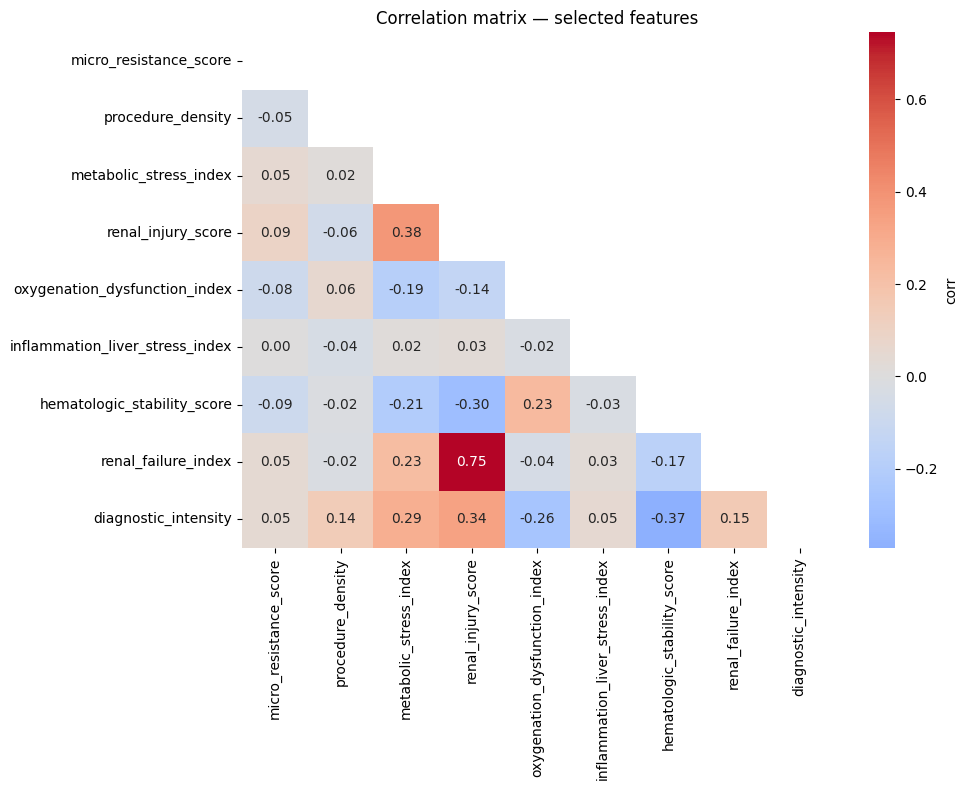

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\new_indicators_only_corr.png
Numeric features used (9): ['micro_resistance_score', 'procedure_density', 'metabolic_stress_index', 'renal_injury_score', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index', 'diagnostic_intensity']
High-corr pairs (|r| >= 0.7): 1
  renal_injury_score <--> renal_failure_index  :  0.745

Running correlation: indicators_plus_non_components (Excluding 23 raw components)


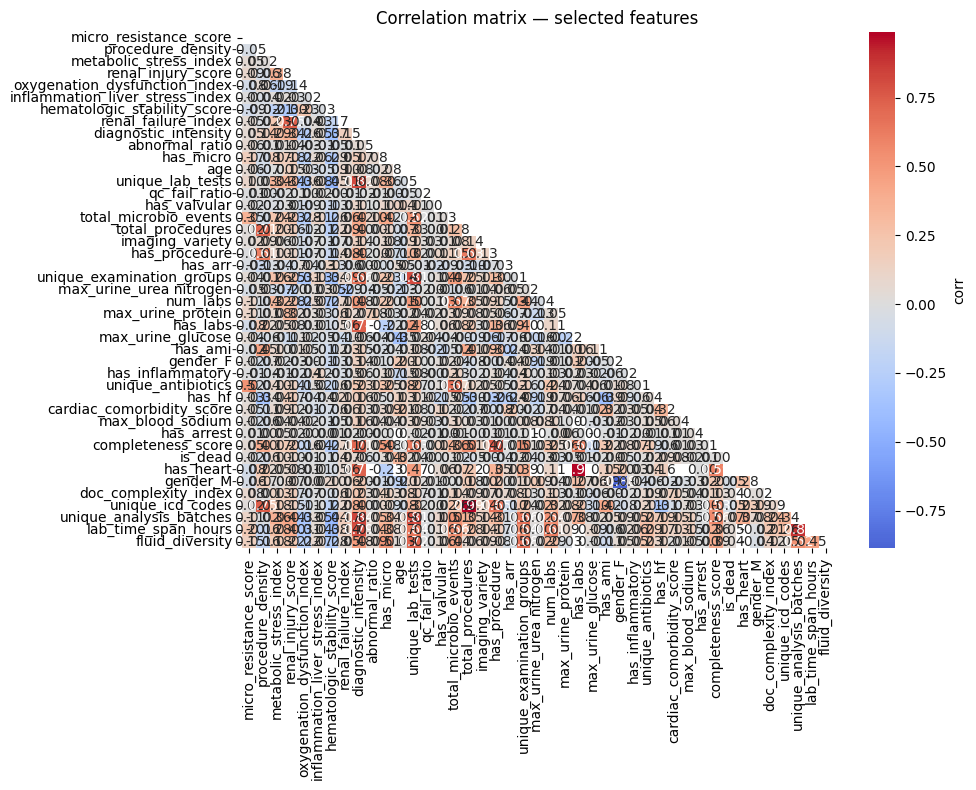

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\indicators_plus_non_components_corr.png
Numeric features used (43): ['micro_resistance_score', 'procedure_density', 'metabolic_stress_index', 'renal_injury_score', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index', 'diagnostic_intensity', 'abnormal_ratio', 'has_micro', 'age', 'unique_lab_tests', 'qc_fail_ratio', 'has_valvular', 'total_microbio_events', 'total_procedures', 'imaging_variety', 'has_procedure', 'has_arr', 'unique_examination_groups', 'max_urine_urea nitrogen', 'num_labs', 'max_urine_protein', 'has_labs', 'max_urine_glucose', 'has_ami', 'gender_F', 'has_inflammatory', 'unique_antibiotics', 'has_hf', 'cardiac_comorbidity_score', 'max_blood_sodium', 'has_arrest', 'completeness_score', 'is_dead', 'has_heart', 'gender_M', 'doc_complexity_index', 'unique_icd_codes', 'unique_analysis_batches', 'lab_time_span_hours',

In [29]:
patient_profile_new, corr_res, found_components = compute_indicators_and_run_corr(patient_profile, data_dir=DATA_DIR, save_plots=True)

In [23]:
found_components

{'count_blood_gas',
 'count_cardiac',
 'count_cbc',
 'count_liver',
 'max_blood_anion gap',
 'max_blood_c-reactive protein',
 'max_blood_creatinine',
 'max_blood_glucose',
 'max_blood_lactate',
 'max_blood_potassium',
 'max_blood_urea nitrogen',
 'max_gas_base excess',
 'max_gas_pCO2',
 'max_gas_pH',
 'max_gas_pO2',
 'max_urine_creatinine',
 'max_urine_sodium',
 'min_blood_hematocrit',
 'min_blood_hemoglobin',
 'procedure_span_days',
 'resistant_ratio',
 'unique_organisms',
 'unique_specimen_types'}

## Drop correlated columns

In [24]:
patient_profile_new.shape

(5166, 72)

In [33]:
to_drop = [
    ## dont dont need them anymore
    'has_heart', 'has_labs', 'has_procedure', 'has_micro',

    ## rest high corr
        'renal_injury_score',
        'gender_M',
        'unique_lab_tests',
        'completeness_score',
        'lab_time_span_hours',
        'unique_icd_codes',
        'diagnostic_intensity',
]
   
to_drop = to_drop + list(found_components)
print(f"Dropping {len(to_drop)} columns used as components or indicators: {to_drop}")

patient_profile_new = patient_profile_new.drop(columns=[c for c in to_drop if c in patient_profile_new.columns])

len(patient_profile_new.columns), patient_profile_new.columns

Dropping 34 columns used as components or indicators: ['has_heart', 'has_labs', 'has_procedure', 'has_micro', 'renal_injury_score', 'gender_M', 'unique_lab_tests', 'completeness_score', 'lab_time_span_hours', 'unique_icd_codes', 'diagnostic_intensity', 'max_blood_glucose', 'count_cardiac', 'max_blood_anion gap', 'min_blood_hematocrit', 'count_liver', 'max_gas_pCO2', 'max_blood_lactate', 'count_cbc', 'count_blood_gas', 'procedure_span_days', 'max_gas_base excess', 'max_gas_pO2', 'max_gas_pH', 'max_blood_urea nitrogen', 'max_urine_sodium', 'max_urine_creatinine', 'unique_specimen_types', 'unique_organisms', 'max_blood_potassium', 'max_blood_c-reactive protein', 'resistant_ratio', 'min_blood_hemoglobin', 'max_blood_creatinine']


(38,
 Index(['subject_id', 'hadm_id', 'age', 'is_dead', 'charttime', 'icd_code',
        'icd_cat', 'imaging_variety', 'doc_complexity_index',
        'cardiac_comorbidity_score', 'has_hf', 'has_arr', 'has_ami',
        'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs',
        'abnormal_ratio', 'qc_fail_ratio', 'unique_examination_groups',
        'fluid_diversity', 'unique_analysis_batches', 'max_blood_sodium',
        'max_urine_glucose', 'max_urine_urea nitrogen', 'max_urine_protein',
        'total_microbio_events', 'unique_antibiotics', 'total_procedures',
        'gender_F', 'gender_missing', 'micro_resistance_score',
        'procedure_density', 'metabolic_stress_index',
        'oxygenation_dysfunction_index', 'inflammation_liver_stress_index',
        'hematologic_stability_score', 'renal_failure_index'],
       dtype='object'))

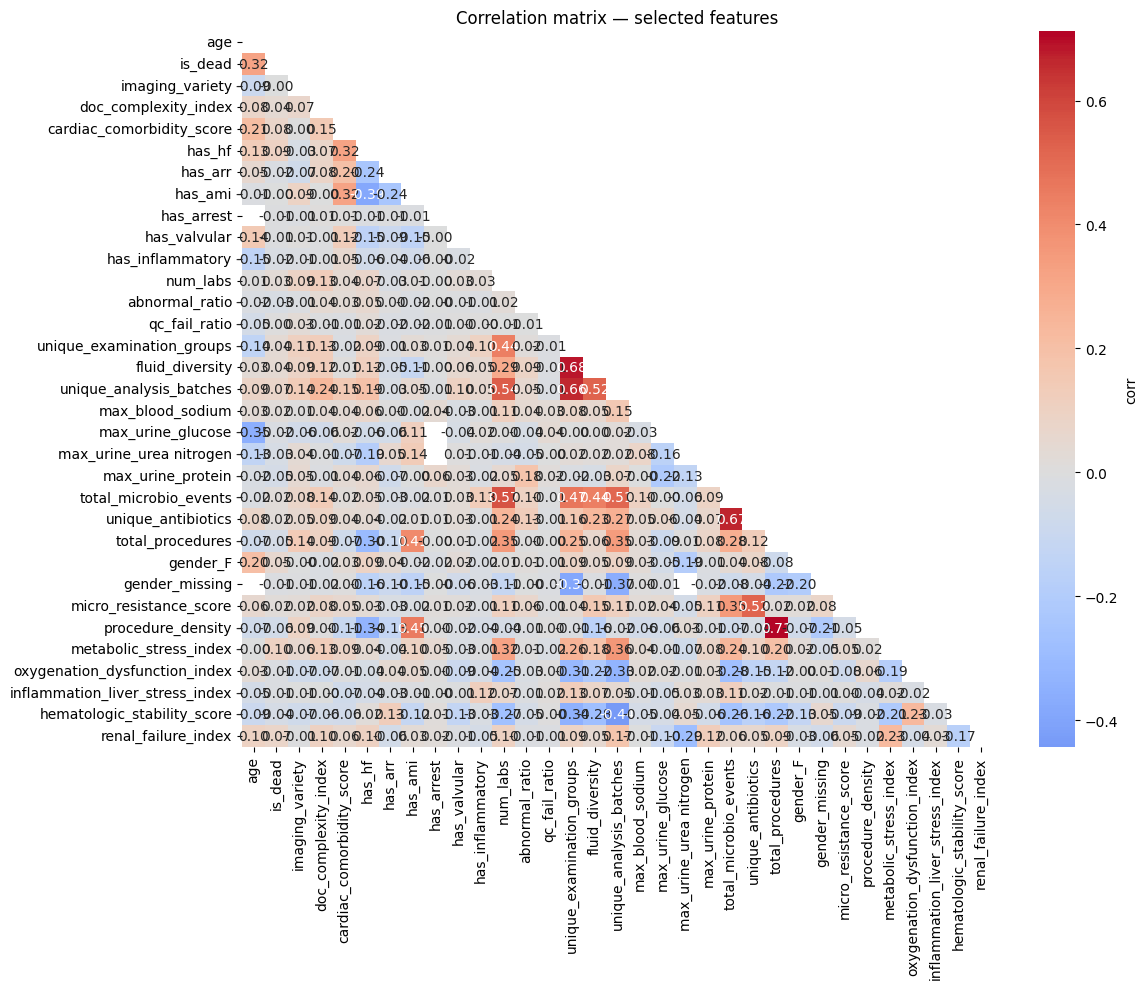

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\selected_features_corr.png
Numeric features used (33): ['age', 'is_dead', 'imaging_variety', 'doc_complexity_index', 'cardiac_comorbidity_score', 'has_hf', 'has_arr', 'has_ami', 'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'unique_examination_groups', 'fluid_diversity', 'unique_analysis_batches', 'max_blood_sodium', 'max_urine_glucose', 'max_urine_urea nitrogen', 'max_urine_protein', 'total_microbio_events', 'unique_antibiotics', 'total_procedures', 'gender_F', 'gender_missing', 'micro_resistance_score', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']
High-corr pairs (|r| >= 0.7): 1
  total_procedures <--> procedure_density  :  0.712


In [34]:
sel = [c for c in patient_profile_new.columns if c not in ('subject_id', 'hadm_id')]

corr_df, high_pairs, used = corr_report(patient_profile_new, sel, data_dir=DATA_DIR, threshold=0.70)

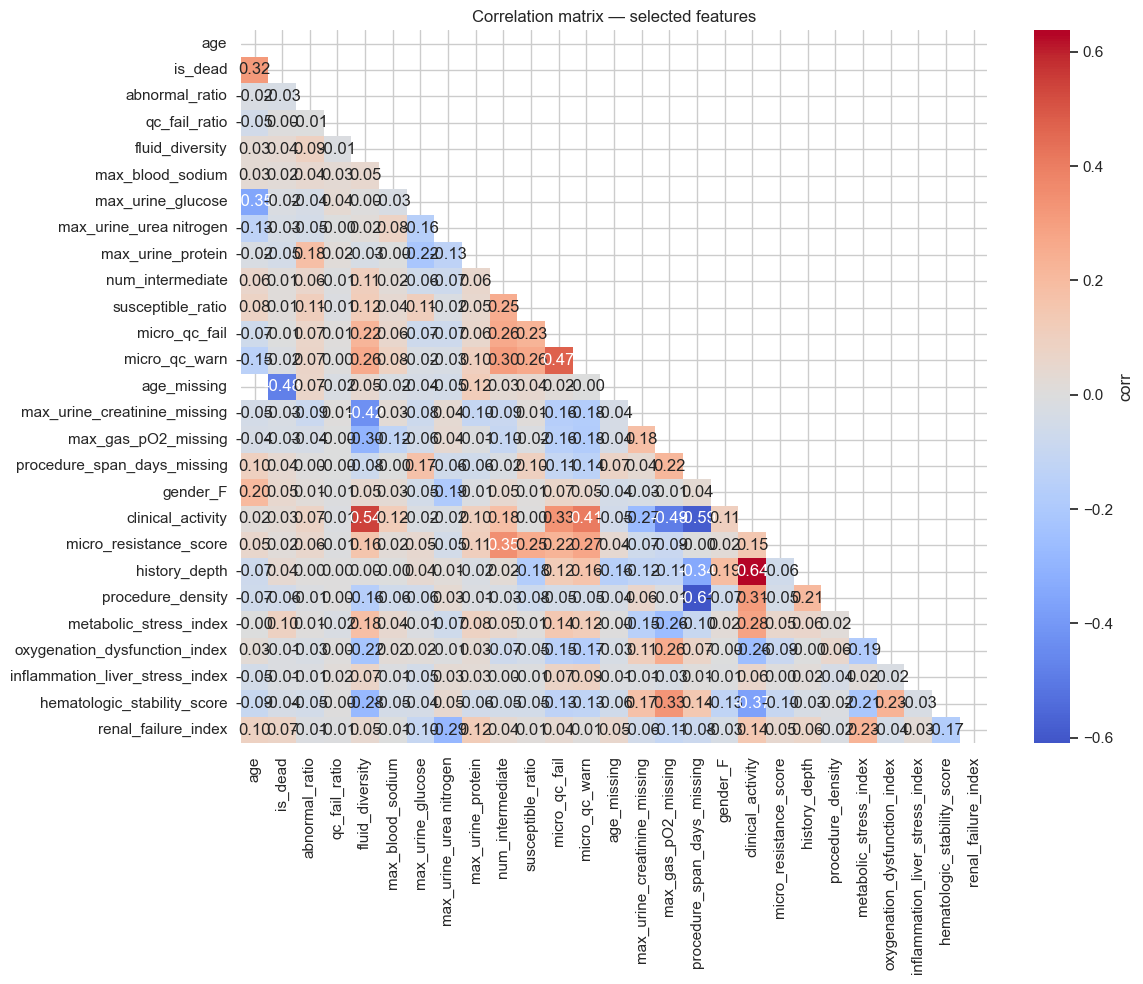

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\selected_features_corr.png
Numeric features used (27): ['age', 'is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'max_urine_glucose', 'max_urine_urea nitrogen', 'max_urine_protein', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']
High-corr pairs (|r| >= 0.7): 0


In [419]:
# Ensure bool/has_ are numeric
sel = [c for c in patient_profile_new.columns if c not in ('subject_id', 'hadm_id')]
corr_df, high_pairs, used = corr_report(patient_profile_new, sel, data_dir=DATA_DIR, threshold=0.70)

# Save this uncorrelated broad profile large "master" (with nans tho)

In [35]:
patient_profile_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       5166 non-null   int64  
 1   hadm_id                          5166 non-null   int64  
 2   age                              1363 non-null   float64
 3   is_dead                          4864 non-null   float64
 4   charttime                        4864 non-null   object 
 5   icd_code                         4864 non-null   object 
 6   icd_cat                          4864 non-null   object 
 7   imaging_variety                  4864 non-null   float64
 8   doc_complexity_index             4864 non-null   float64
 9   cardiac_comorbidity_score        4864 non-null   float64
 10  has_hf                           5166 non-null   int64  
 11  has_arr                          5166 non-null   int64  
 12  has_ami             

In [36]:
patient_profile_new.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,5166.0,1.539306e+07,3.073751e+06,1.000098e+07,1.267767e+07,1.539807e+07,1.812905e+07,1.999860e+07
hadm_id,5166.0,2.501832e+07,2.871364e+06,2.000446e+07,2.261127e+07,2.502269e+07,2.746995e+07,2.999967e+07
age,1363.0,6.897872e+01,1.497336e+01,1.800000e+01,6.000000e+01,7.000000e+01,8.100000e+01,9.500000e+01
is_dead,4864.0,8.182566e-02,2.741271e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
imaging_variety,4864.0,3.297081e+00,5.291655e-01,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
doc_complexity_index,4864.0,2.230601e+01,1.271144e+00,1.722996e+01,2.148126e+01,2.230973e+01,2.317492e+01,2.765688e+01
cardiac_comorbidity_score,4864.0,8.022204e-01,3.983660e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
has_hf,5166.0,2.801007e-01,4.490917e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
has_arr,5166.0,1.312427e-01,3.376983e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
has_ami,5166.0,2.785521e-01,4.483299e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [44]:
patient_profile_new.to_csv(os.path.join(data_save_path, "patient_profile_master_large.csv"), index=False)

# FInal DU of patient prfile broad

In [46]:
patient_profile_large = patient_profile_new.copy()

In [47]:
patient_profile_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       5166 non-null   int64  
 1   hadm_id                          5166 non-null   int64  
 2   age                              1363 non-null   float64
 3   is_dead                          4864 non-null   float64
 4   charttime                        4864 non-null   object 
 5   icd_code                         4864 non-null   object 
 6   icd_cat                          4864 non-null   object 
 7   imaging_variety                  4864 non-null   float64
 8   doc_complexity_index             4864 non-null   float64
 9   cardiac_comorbidity_score        4864 non-null   float64
 10  has_hf                           5166 non-null   int64  
 11  has_arr                          5166 non-null   int64  
 12  has_ami             

In [48]:
patient_profile_large.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,5166.0,1.539306e+07,3.073751e+06,1.000098e+07,1.267767e+07,1.539807e+07,1.812905e+07,1.999860e+07
hadm_id,5166.0,2.501832e+07,2.871364e+06,2.000446e+07,2.261127e+07,2.502269e+07,2.746995e+07,2.999967e+07
age,1363.0,6.897872e+01,1.497336e+01,1.800000e+01,6.000000e+01,7.000000e+01,8.100000e+01,9.500000e+01
is_dead,4864.0,8.182566e-02,2.741271e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
imaging_variety,4864.0,3.297081e+00,5.291655e-01,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
doc_complexity_index,4864.0,2.230601e+01,1.271144e+00,1.722996e+01,2.148126e+01,2.230973e+01,2.317492e+01,2.765688e+01
cardiac_comorbidity_score,4864.0,8.022204e-01,3.983660e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
has_hf,5166.0,2.801007e-01,4.490917e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
has_arr,5166.0,1.312427e-01,3.376983e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
has_ami,5166.0,2.785521e-01,4.483299e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


Boxplots saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\patient_profile_large_boxplots_grid.png


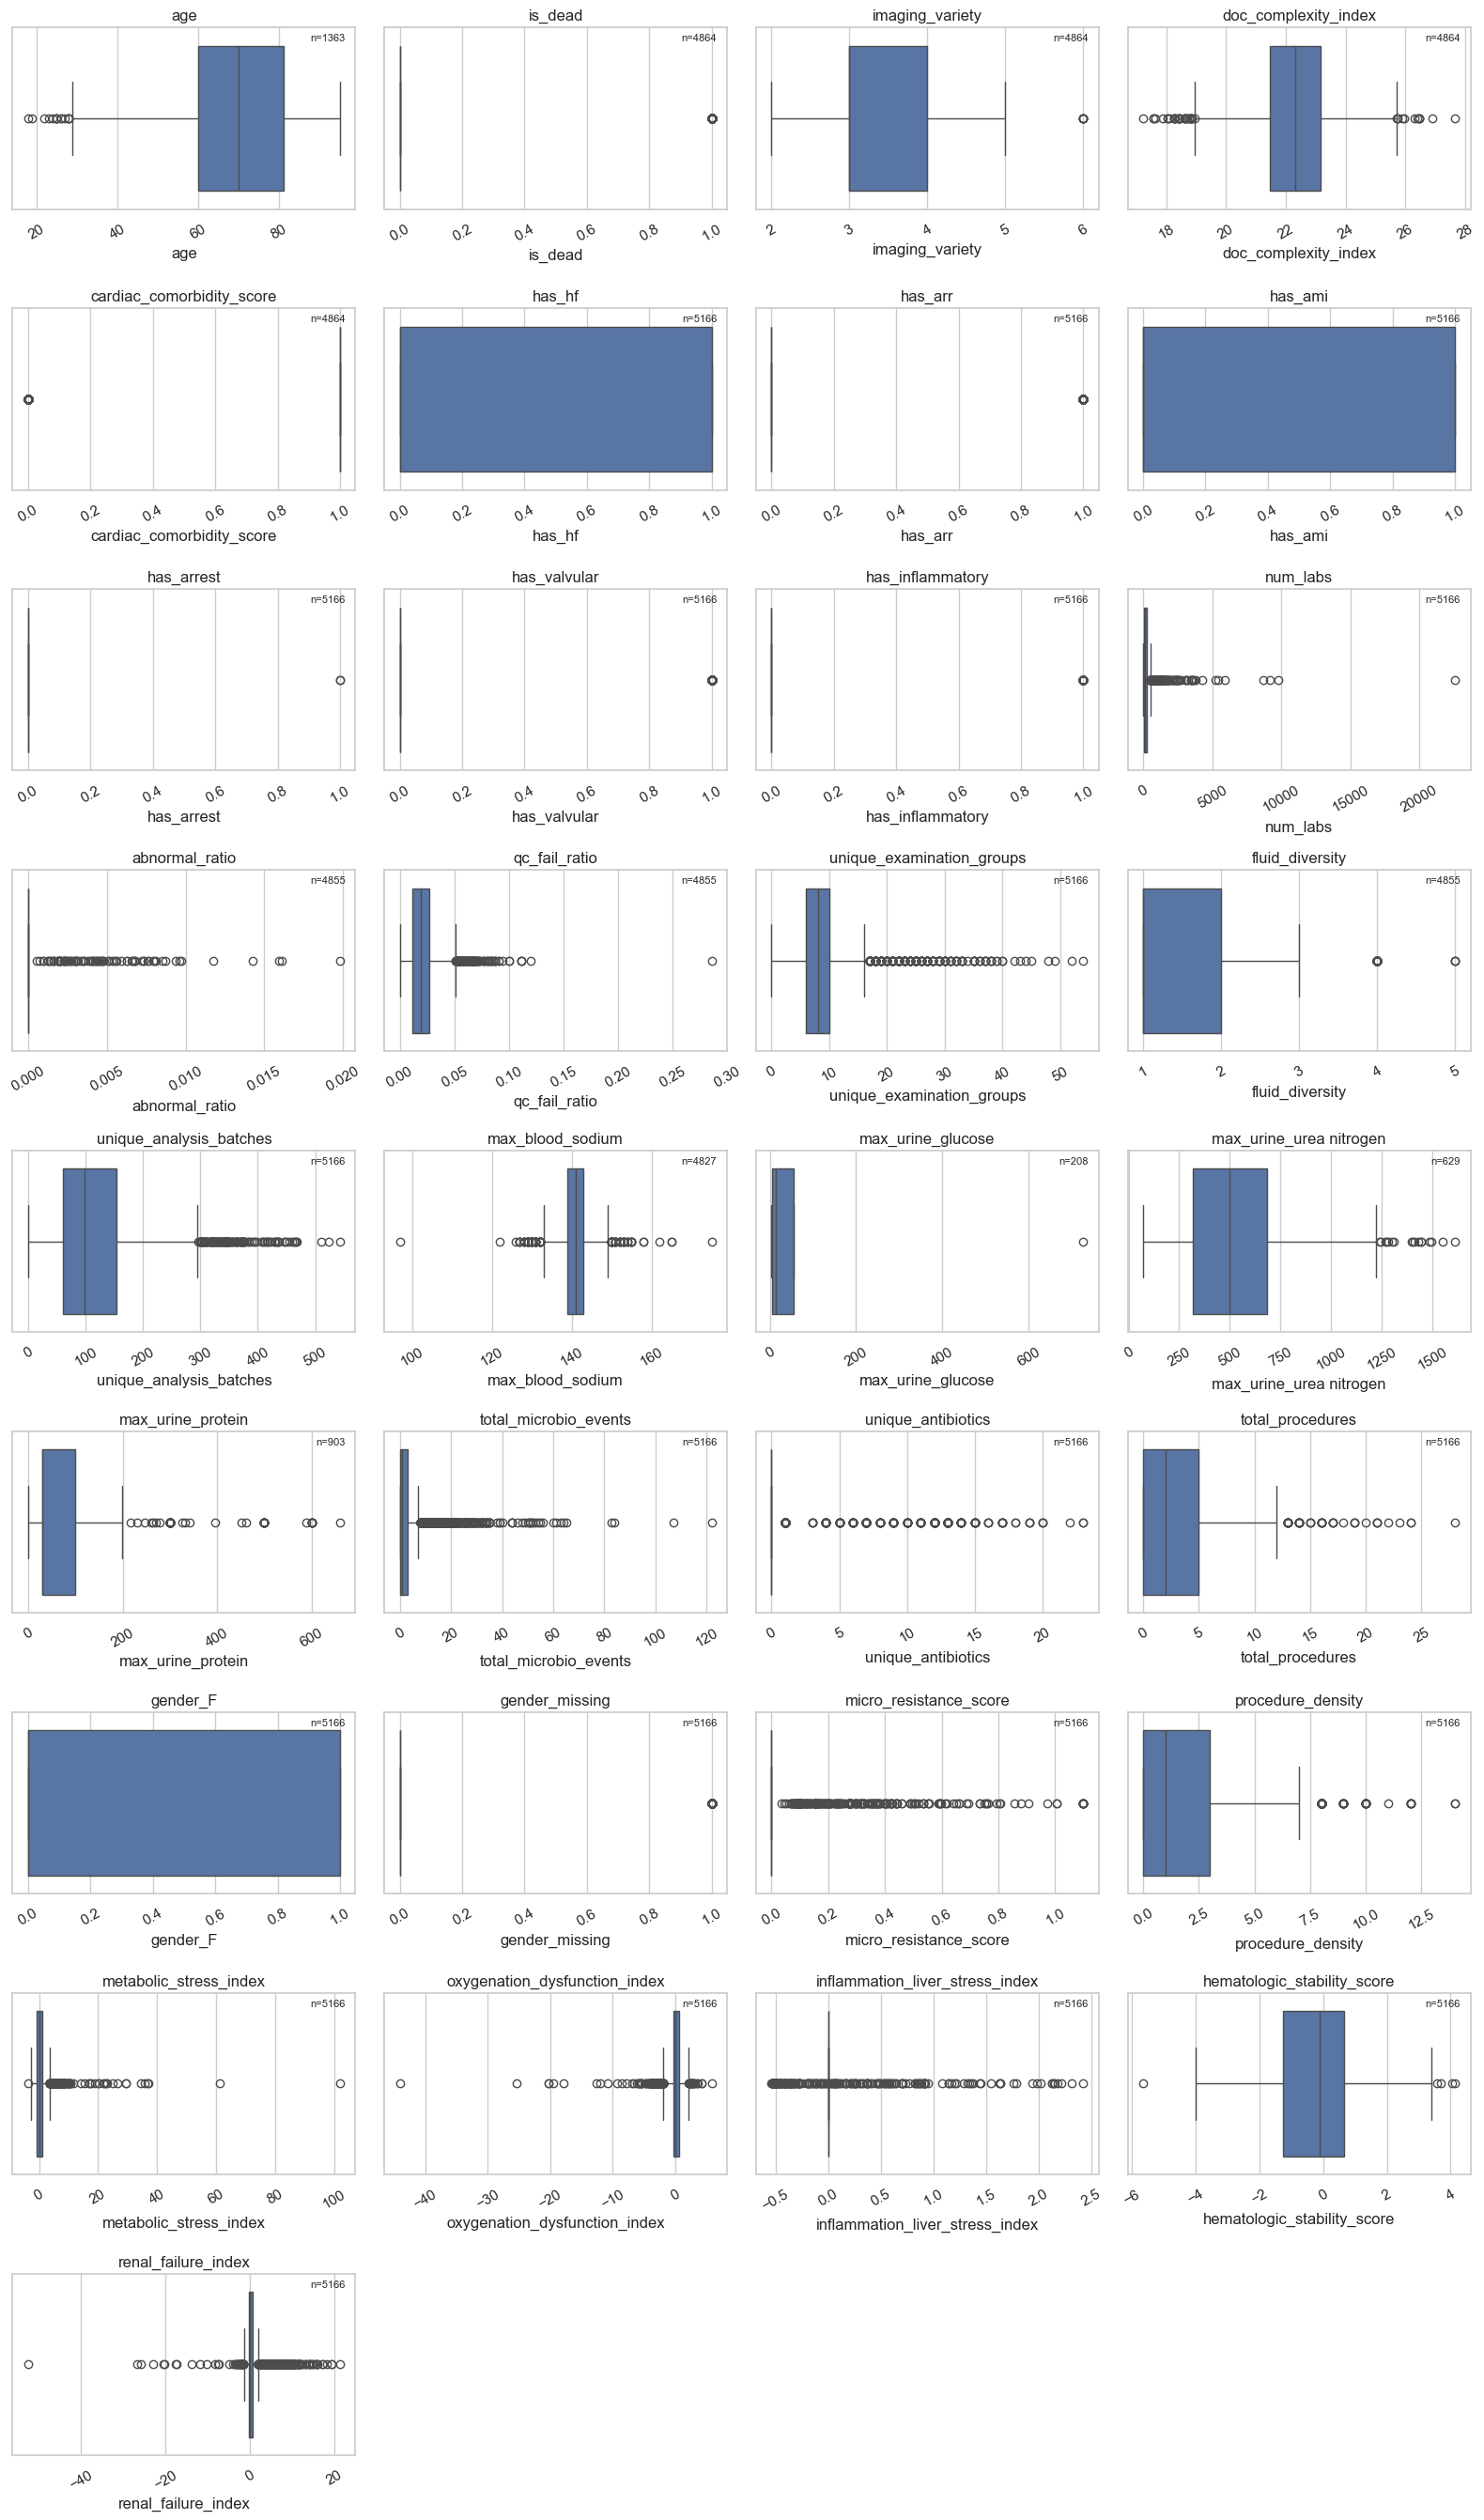

In [52]:
# Boxplots for all numeric columns in patient_profile_large (exclude ids)
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

num_cols = [c for c in patient_profile_large.select_dtypes(include=[np.number]).columns
            if c not in ('subject_id', 'hadm_id')]
if not num_cols:
    print("No numeric columns found for boxplots.")
else:
    cols_per_row = 4
    n = len(num_cols)
    rows = math.ceil(n / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(num_cols):
        ax = axes[i]
        # avoid plotting infinite values
        series = patient_profile_large[col].replace([np.inf, -np.inf], np.nan).dropna()
        if series.empty:
            ax.text(0.5, 0.5, "no data", ha='center', va='center')
            ax.set_title(col)
            continue
        sns.boxplot(x=series, ax=ax, color='C0')
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=30)
        ax.text(0.97, 0.97, f"n={len(series)}", transform=ax.transAxes,
                ha='right', va='top', fontsize=8)

    # turn off any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    os.makedirs(os.path.join(DATA_DIR, 'plots'), exist_ok=True)
    out_path = os.path.join(DATA_DIR, 'plots', 'patient_profile_large_boxplots_grid.png')
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    print(f"Boxplots saved to: {out_path}")
    plt.show()

In [50]:
constant_cols = [col for col in patient_profile_large.columns if patient_profile_large[col].nunique() <= 1]
print(f"{len(constant_cols)} constant columns: {constant_cols}")

0 constant columns: []


# Handle NaNs generally if possible

In [61]:
patient_profile_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       5166 non-null   int64  
 1   hadm_id                          5166 non-null   int64  
 2   age                              1363 non-null   float64
 3   is_dead                          4864 non-null   float64
 4   charttime                        4864 non-null   object 
 5   icd_code                         4864 non-null   object 
 6   icd_cat                          4864 non-null   object 
 7   imaging_variety                  4864 non-null   float64
 8   doc_complexity_index             4864 non-null   float64
 9   cardiac_comorbidity_score        4864 non-null   float64
 10  has_hf                           5166 non-null   int64  
 11  has_arr                          5166 non-null   int64  
 12  has_ami             

In [66]:
# TODO handle Nans:   by other columns, gneder, age, icd_cat, ....
# dont do age and gender bc hard 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# drop urine mertrics
patient_profile_large_clean = patient_profile_large.copy()
patient_profile_large_clean.drop(columns=['max_urine_glucose', 'max_urine_urea nitrogen', 'max_urine_protein', ], inplace=True)

# 3. FILL Indices (8, 9, 22) using MICE 
# We use the 100% full features (33-37) to predict the 6% missing indices
imputer = IterativeImputer(random_state=42)
cols_to_fix = [
    'doc_complexity_index', 'cardiac_comorbidity_score', 'max_blood_sodium',
    'metabolic_stress_index', 'oxygenation_dysfunction_index', 
    'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index'
]
patient_profile_large_clean[cols_to_fix] = imputer.fit_transform(patient_profile_large_clean[cols_to_fix])

# 4. AGE IMPUTATION: Use the median age of the ICD Category
# If icd_cat is 'Cardiac', we give them the median age of other Cardiac patients
patient_profile_large_clean['age'] = patient_profile_large_clean['age'].fillna(patient_profile_large_clean.groupby('icd_cat')['age'].transform('median'))

# 5. FINAL SAFETY: If any ages are still missing (because a whole icd_cat was NaN)
patient_profile_large_clean['age'] = patient_profile_large_clean['age'].fillna(patient_profile_large_clean['age'].median())
patient_profile_large_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       5166 non-null   int64  
 1   hadm_id                          5166 non-null   int64  
 2   age                              5166 non-null   float64
 3   is_dead                          4864 non-null   float64
 4   charttime                        4864 non-null   object 
 5   icd_code                         4864 non-null   object 
 6   icd_cat                          4864 non-null   object 
 7   imaging_variety                  4864 non-null   float64
 8   doc_complexity_index             5166 non-null   float64
 9   cardiac_comorbidity_score        5166 non-null   float64
 10  has_hf                           5166 non-null   int64  
 11  has_arr                          5166 non-null   int64  
 12  has_ami             

# Create clustering sub profile Large

In [56]:
patient_profile_large.columns

Index(['subject_id', 'hadm_id', 'age', 'is_dead', 'charttime', 'icd_code',
       'icd_cat', 'imaging_variety', 'doc_complexity_index',
       'cardiac_comorbidity_score', 'has_hf', 'has_arr', 'has_ami',
       'has_arrest', 'has_valvular', 'has_inflammatory', 'num_labs',
       'abnormal_ratio', 'qc_fail_ratio', 'unique_examination_groups',
       'fluid_diversity', 'unique_analysis_batches', 'max_blood_sodium',
       'max_urine_glucose', 'max_urine_urea nitrogen', 'max_urine_protein',
       'total_microbio_events', 'unique_antibiotics', 'total_procedures',
       'gender_F', 'gender_missing', 'micro_resistance_score',
       'procedure_density', 'metabolic_stress_index',
       'oxygenation_dysfunction_index', 'inflammation_liver_stress_index',
       'hematologic_stability_score', 'renal_failure_index'],
      dtype='object')

## Biological / Pure Physiological patient state 
Profile A: The "Clinical Severity" Profile (For K-Means/GMM Clustering)
This profile ignores binary flags and focuses on the degree of organ dysfunction.

 'doc_complexity_index',
        'cardiac_comorbidity_score', 'num_labs', 'micro_resistance_score',
        'procedure_density', 'metabolic_stress_index',
        'oxygenation_dysfunction_index', 'inflammation_liver_stress_index',
        'hematologic_stability_score', 'renal_failure_index'

Math Prep: Must be Z-score standardized.

Goal: Identify "how sick" the patient is, regardless of their specific diagnosis.

Characterization: "High-Stress/Low-Renal" vs "Low-Stress/High-Renal" phenotypes.

In [58]:
to_drop = ['age', 'is_dead', 'charttime', 'icd_code',
       'icd_cat', 'imaging_variety', 
       'has_hf', 'has_arr', 'has_ami',
       'has_arrest', 'has_valvular', 'has_inflammatory', 
       'abnormal_ratio', 'qc_fail_ratio', 'unique_examination_groups',
       'fluid_diversity', 'unique_analysis_batches', 'max_blood_sodium',
       'max_urine_glucose', 'max_urine_urea nitrogen', 'max_urine_protein',
       'total_microbio_events', 'unique_antibiotics', 'total_procedures',
       'gender_F', 'gender_missing']

patient_profile_clustering_biological = patient_profile_large.copy()
patient_profile_clustering_biological.drop(columns=to_drop, inplace=True)
patient_profile_clustering_biological.columns, patient_profile_clustering_biological.shape


(Index(['subject_id', 'hadm_id', 'doc_complexity_index',
        'cardiac_comorbidity_score', 'num_labs', 'micro_resistance_score',
        'procedure_density', 'metabolic_stress_index',
        'oxygenation_dysfunction_index', 'inflammation_liver_stress_index',
        'hematologic_stability_score', 'renal_failure_index'],
       dtype='object'),
 (5166, 12))

In [71]:
#Nans?
patient_profile_clustering_biological.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4864 entries, 0 to 5165
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       4864 non-null   int64  
 1   hadm_id                          4864 non-null   int64  
 2   doc_complexity_index             4864 non-null   float64
 3   cardiac_comorbidity_score        4864 non-null   float64
 4   num_labs                         4864 non-null   float64
 5   micro_resistance_score           4864 non-null   float64
 6   procedure_density                4864 non-null   float64
 7   metabolic_stress_index           4864 non-null   float64
 8   oxygenation_dysfunction_index    4864 non-null   float64
 9   inflammation_liver_stress_index  4864 non-null   float64
 10  hematologic_stability_score      4864 non-null   float64
 11  renal_failure_index              4864 non-null   float64
dtypes: float64(10), int64(2)


In [70]:
patient_profile_clustering_biological.dropna(inplace=True)


In [72]:
patient_profile_clustering_biological.to_csv(os.path.join(data_save_path, "patient_profile_clustering_biological.csv"), index=False)


In [ ]:
# mean inmpute doc by subject_id, hadm_id if possible 

## 3 way split by gender (F, M, missing gender)

In [ ]:
# 3-way split by gender (F, M, missing)
from sklearn.preprocessing import StandardScaler

print("="*80)
print("3-WAY GENDER SPLIT WITH Z-SCORE STANDARDIZATION")
print("="*80)

# Get gender info from original patient_profile_large
gender_data = patient_profile_large[['subject_id', 'hadm_id', 'gender_F', 'gender_M', 'gender_missing']].copy()

# Merge with clustering biological data
clustering_with_gender = patient_profile_clustering_biological.merge(
    gender_data, 
    on=['subject_id', 'hadm_id'], 
    how='left'
)

print(f"\nOriginal clustering data shape: {patient_profile_clustering_biological.shape}")
print(f"After adding gender: {clustering_with_gender.shape}")

# Define splits
gender_splits = {
    'Female': clustering_with_gender[clustering_with_gender['gender_F'] == 1].drop(columns=['gender_F', 'gender_M', 'gender_missing']),
    'Male': clustering_with_gender[clustering_with_gender['gender_M'] == 1].drop(columns=['gender_F', 'gender_M', 'gender_missing']),
    'Missing': clustering_with_gender[clustering_with_gender['gender_missing'] == 1].drop(columns=['gender_F', 'gender_M', 'gender_missing'])
}

# Display split sizes
print("\n" + "-"*80)
print("SPLIT SIZES:")
print("-"*80)
for gender_name, df_split in gender_splits.items():
    pct = len(df_split) / len(clustering_with_gender) * 100
    print(f"{gender_name:15s}: {len(df_split):,} samples ({pct:5.1f}%)")

# Z-score standardize each split
print("\n" + "-"*80)
print("Z-SCORE STANDARDIZATION FOR EACH SPLIT:")
print("-"*80)

gender_splits_standardized = {}
scalers = {}

for gender_name, df_split in gender_splits.items():
    if len(df_split) == 0:
        print(f"\n{gender_name}: EMPTY (skipping)")
        continue
    
    print(f"\n{gender_name} ({len(df_split)} samples):")
    
    # Store IDs
    ids = df_split[['subject_id', 'hadm_id']].copy()
    
    # Get numeric columns
    id_cols = ['subject_id', 'hadm_id']
    numeric_cols = [col for col in df_split.select_dtypes(include=[np.number]).columns 
                    if col not in id_cols]
    
    # Data to standardize
    data_to_std = df_split[numeric_cols].copy()
    
    # Handle NaNs: fill with mean
    data_to_std_filled = data_to_std.fillna(data_to_std.mean())
    
print("\n" + "="*80)
print("STANDARDIZED SPLITS READY FOR CLUSTERING")
print("="*80)

# Display summary
for gender_name, df_std in gender_splits_standardized.items():
    print(f"\n{gender_name}:")
    print(df_std.describe().T)


In [51]:
# TODO ECXLUDE AND FEATURE WHICH HAS PART OF ICD CODE!! bc target is icd code
# TODO All columns except charttime and high-NaN urine columns.

In [ ]:
# impute age
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_absolute_error

# 1. PREP: Subset data that HAS age to use as a gold-standard test set
df_test = df[df['age'].notna()].copy()

# 2. SIMULATE MISSINGNESS: Hide 20% of the ages in our test set
np.random.seed(42)
ix = df_test.sample(frac=0.2).index
y_true = df_test.loc[ix, 'age']
df_test.loc[ix, 'age'] = np.nan

# --- METHOD A: Global Median ---
median_val = df['age'].median()
pred_a = df_test.loc[ix, 'age'].fillna(median_val)
mae_a = mean_absolute_error(y_true, pred_a)

# --- METHOD B: Groupby ICD Category ---
# We calculate the median age for each category from the original data
cat_medians = df.groupby('icd_cat')['age'].median()
pred_b = df_test.loc[ix].apply(
    lambda row: cat_medians[row['icd_cat']] if pd.isna(row['age']) else row['age'], axis=1
)
mae_b = mean_absolute_error(y_true, pred_b.loc[ix])

# --- METHOD C: Iterative Imputer (MICE) ---
# This uses other clinical indices to "predict" the missing age
mice = IterativeImputer(random_state=42)
# Select columns that are likely correlated with age (Complexity, Stress, etc.)
cols = ['age', 'doc_complexity_index', 'metabolic_stress_index', 'renal_failure_index']
mice_data = mice.fit_transform(df_test[cols])
pred_c = mice_data[df_test.index.get_indexer(ix), 0]
mae_c = mean_absolute_error(y_true, pred_c)

print(f"Global Median MAE: {mae_a:.2f}")
print(f"ICD-Category Median MAE: {mae_b:.2f}")
print(f"MICE (Predictive) MAE: {mae_c:.2f}")

## Handle NaNs


In [ ]:
from sklearn.impute import SimpleImputer
df_work = patient_profile_large.copy()

# 1) Drop columns with too many NaNs or not desired
cols_to_drop = ['age', 'max_urine_glucose', 'max_urine_urea nitrogen', 'max_urine_protein']   # too sparse!
df_work = df_work.drop(columns=[c for c in cols_to_drop if c in df_work.columns], errors='ignore')

# impute with 0: columns where missingness usually implies "normalcy" or "neutrality"
for col in ['is_dead', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'fluid_diversity', 'abnormal_ratio', 'qc_fail_ratio' ]:
    if col in df_work.columns:
        df_work[col] = pd.to_numeric(df_work[col], errors='coerce').fillna(0.0)

# # 4) Median impute: Using 0 would make the patient look dead or biologically impossible + enough other data points
# for col in ['max_blood_sodium']: 
#     if col in df_work.columns:
#         imp = SimpleImputer(strategy='median')
#         df_work[[col]] = imp.fit_transform(df_work[[col]])

final_profile_broad = df_work.copy()
final_profile_broad.to_csv(os.path.join(data_save_path, "patient_profile_broad.csv"), index=False)
final_profile_broad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   subject_id                       5166 non-null   int64  
 1   hadm_id                          5166 non-null   float64
 2   is_dead                          5166 non-null   float64
 3   abnormal_ratio                   5166 non-null   float64
 4   qc_fail_ratio                    5166 non-null   float64
 5   fluid_diversity                  5166 non-null   float64
 6   max_blood_sodium                 5166 non-null   float64
 7   num_intermediate                 5166 non-null   float64
 8   susceptible_ratio                5166 non-null   float64
 9   micro_qc_fail                    5166 non-null   float64
 10  micro_qc_warn                    5166 non-null   float64
 11  age_missing                      5166 non-null   int64  
 12  max_urine_creatinine

In [441]:
# 2. Identify 'Constant' columns (columns where everyone has the same value)
# In a smaller subset, many has_ columns often become 100% '1'
constant_cols = [col for col in final_profile_broad.columns if final_profile_broad[col].nunique() <= 1]

print(f"Dropping {len(constant_cols)} constant columns: {constant_cols}")

# 3. Drop them
df_clean_broad = final_profile_broad.drop(columns=constant_cols).copy()

# 4. Identify 'Redundant' has_ columns 
# If you have the numeric result (min/max), the has_ indicator is 100% redundant
redundant_indicators = []
for col in df_clean_broad.columns:
    if col.startswith('has_'):
        lab_name = col.replace('has_', '')
        # Check if a numeric version of this lab exists in the columns
        numeric_matches = [c for c in df_clean_broad.columns if lab_name in c and c != col]
        if numeric_matches:
            redundant_indicators.append(col)

print(f"Dropping {len(redundant_indicators)} redundant indicators: {redundant_indicators}")
df_clean_broad = df_clean_broad.drop(columns=redundant_indicators)

print(f"Final feature count for clustering: {len(df_clean_broad.columns)}")

Dropping 0 constant columns: []
Dropping 0 redundant indicators: []
Final feature count for clustering: 25


In [443]:
data_save_path

WindowsPath('Y:/Studium/3. Sem UniPI/Data Analytics 4 digital Health/data_analytics_4_health_unipi/data_analytics_4_health_unipi/Data')

In [444]:
final_profile_broad = df_clean_broad.copy()
final_profile_broad.to_csv(os.path.join(data_save_path, "patient_profile_broad_clean.csv"), index=False)

Distribution of is_dead: std=0.267, mean=0.077
Distribution of abnormal_ratio: std=0.001, mean=0.000
Distribution of qc_fail_ratio: std=0.015, mean=0.019
Distribution of fluid_diversity: std=0.727, mean=1.459
Distribution of max_blood_sodium: std=3.316, mean=141.015
Distribution of num_intermediate: std=0.247, mean=0.030
Distribution of susceptible_ratio: std=0.202, mean=0.058
Distribution of micro_qc_fail: std=0.510, mean=0.151
Distribution of micro_qc_warn: std=0.842, mean=0.304
Distribution of age_missing: std=0.441, mean=0.736
Distribution of max_urine_creatinine_missing: std=0.363, mean=0.844
Distribution of max_gas_pO2_missing: std=0.423, mean=0.767
Distribution of procedure_span_days_missing: std=0.470, mean=0.330
Distribution of gender_F: std=0.488, mean=0.390
Distribution of clinical_activity: std=0.680, mean=1.961
Distribution of micro_resistance_score: std=0.068, mean=0.012
Distribution of history_depth: std=1.778, mean=6.944
Distribution of procedure_density: std=2.371, mea

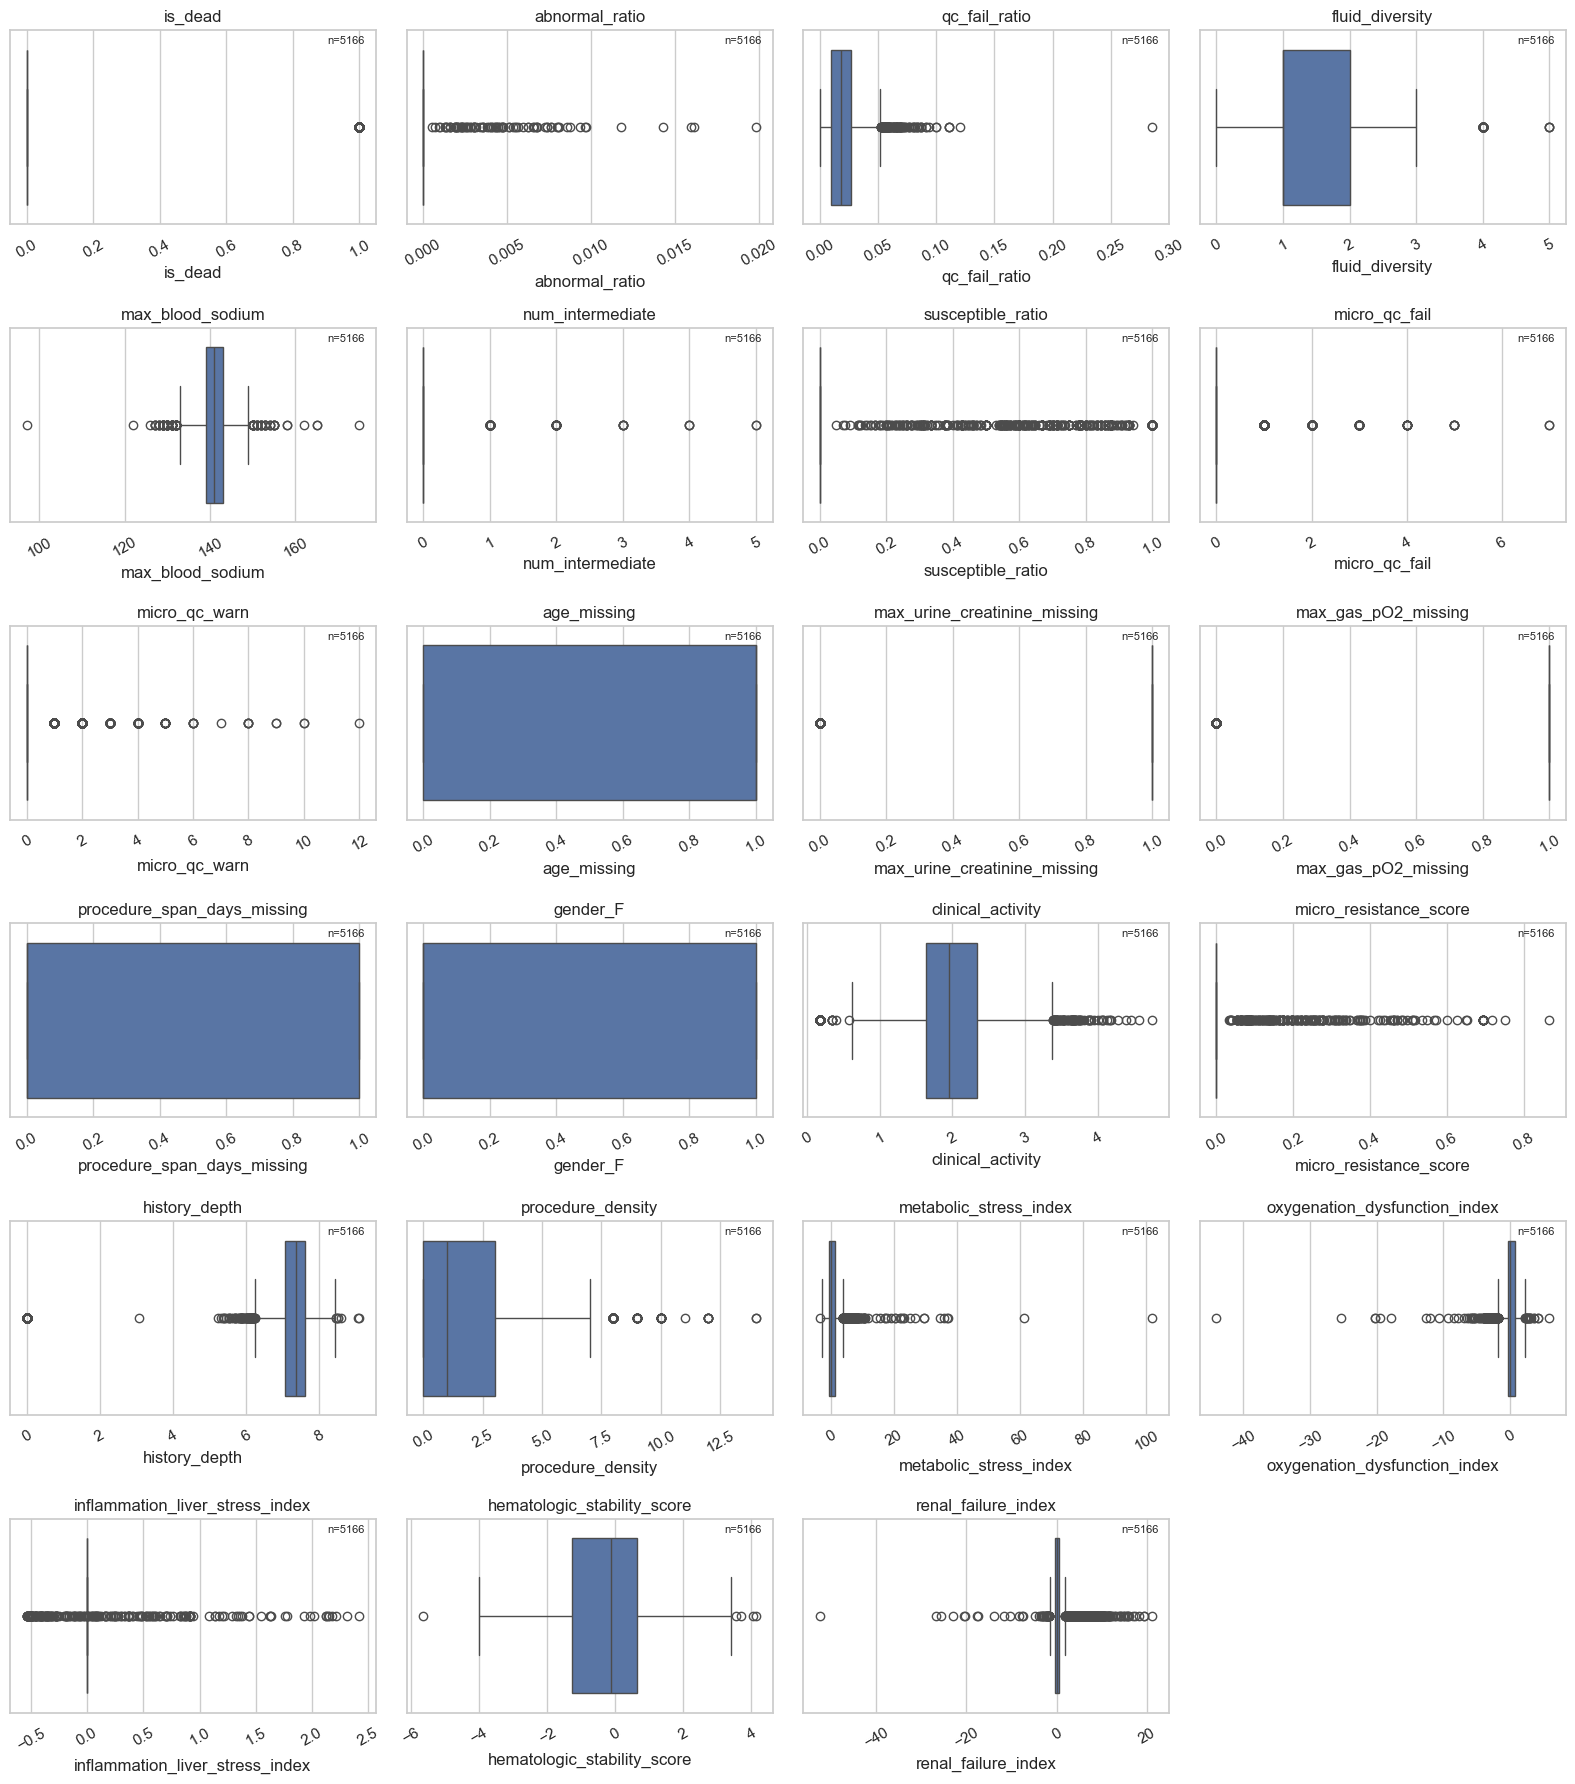

In [445]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

num_cols = [c for c in final_profile_broad.select_dtypes(include=[np.number]).columns
            if c not in ('subject_id', 'hadm_id')]
if not num_cols:
    print("No numeric columns found for boxplots.")
else:
    cols_per_row = 4
    n = len(num_cols)
    rows = math.ceil(n / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 4, rows * 3))
    axes = axes.flatten() if n > 1 else [axes]

    for i, col in enumerate(num_cols):
        print(f"Distribution of {col}: std={final_profile_broad[col].std():.3f}, mean={final_profile_broad[col].mean():.3f}")
        ax = axes[i]
        # avoid plotting infinite values
        series = final_profile_broad[col].replace([np.inf, -np.inf], np.nan).dropna()
        if series.empty:
            ax.text(0.5, 0.5, "no data", ha='center', va='center')
            ax.set_title(col)
            continue
        sns.boxplot(x=series, ax=ax, color='C0')
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=30)
        ax.text(0.97, 0.97, f"n={len(series)}", transform=ax.transAxes,
                ha='right', va='top', fontsize=8)

    # turn off any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    os.makedirs(os.path.join(DATA_DIR, 'plots'), exist_ok=True)
    out_path = os.path.join(DATA_DIR, 'plots', 'patient_profile_broad_boxplots_grid.png')
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    print(f"Boxplots saved to: {out_path}")
    plt.show()

In [448]:
log_features = [
    'procedure_density',
    'history_depth',
    'num_intermediate',
    'fluid_diversity'
]

print("Applying log1p to:", log_features)

for c in log_features:
    final_profile_broad[c] = np.log1p(final_profile_broad[c])
    
final_profile_broad.to_csv(os.path.join(data_save_path, "patient_profile_broad_clean_clustering.csv"), index=False)


Applying log1p to: ['procedure_density', 'history_depth', 'num_intermediate', 'fluid_diversity']


In [449]:
final_profile_broad.drop(columns=["procedure_span_days_missing"], errors='ignore', inplace=True)
final_profile_broad.to_csv(os.path.join(data_save_path, "patient_profile_broad_clean_clustering.csv"), index=False)